# Two-Layer SWM diagnostics
The script is for compring the impacts of number of meridionally oriented ridges in a model forced with surface wind stress.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dask
import dask.distributed
from xgcm import Grid
%matplotlib inline

In [2]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:37684 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 270.45 GB


Specify cases and the main path

In [3]:
n_ridge = [0, 1, 2, 3, 5, 7, 10, 15, 20]
ppdir = "/work/Hemant.Khatri/MOM6_idealised/SWM_Two_Layer/sin_ridge/H_500/"

# Time series of energy

In [4]:
# Read stats file for energy time series
dataset = []
for i in range(0, len(n_ridge)):
    d = xr.open_dataset(ppdir+"H_500_n_"+str(n_ridge[i])+"/ocean.stats.nc") 
    dataset.append(d)
ds = xr.concat(dataset, dim='nr')

In [5]:
ds

<xarray.Dataset>
Dimensions:        (Interface: 3, Layer: 2, Time: 1826, nr: 9)
Coordinates:
  * Interface      (Interface) float64 1.027e+03 1.028e+03 1.028e+03
  * Layer          (Layer) float64 1.027e+03 1.028e+03
  * Time           (Time) timedelta64[ns] 0 days 10 days ... 18250 days
Dimensions without coordinates: nr
Data variables:
    Ntrunc         (nr, Time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    En             (nr, Time) float64 1.332e-09 9.811e+14 ... 2.963e+17
    APE            (nr, Time, Interface) float64 1.332e-09 0.0 ... 2.319e+17 0.0
    KE             (nr, Time, Layer) float64 0.0 0.0 ... 3.018e+16 3.326e+16
    H0             (nr, Time, Interface) float64 4.547e-13 1e+03 ... 1e+03 4e+03
    Mass_lay       (nr, Time, Layer) float64 1.315e+18 3.945e+18 ... 3.735e+18
    Mass           (nr, Time) float64 5.26e+18 5.26e+18 ... 5.05e+18 5.05e+18
    Mass_chg       (nr, Time) float64 0.0 109.3 -48.79 ... 10.63 -5.498 -11.7
    Mass_anom      (nr, Time) float6

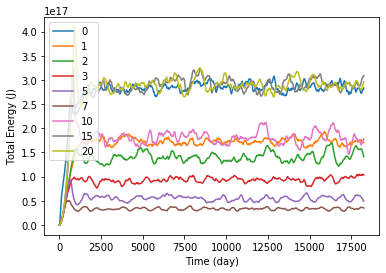

In [6]:
plt.plot(ds.Time/(1e9*3600*24), ds.En.T)
plt.ylabel('Total Energy (J)')
plt.xlabel('Time (day)')
plt.legend(['0','1', '2','3', '5','7', '10','15', '20'])

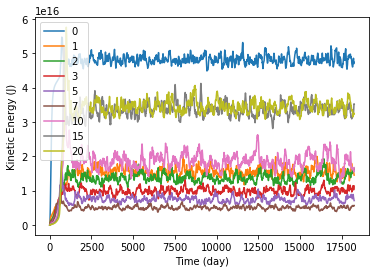

In [8]:
KE = (ds.KE.isel(Layer=0)*1000. + ds.KE.isel(Layer=1)*3000.)/4000.
plt.plot(ds.Time/(1e9*3600*24), KE.T)
plt.ylabel('Kinetic Energy (J)')
plt.xlabel('Time (day)')
plt.legend(['0','1', '2','3', '5','7', '10','15', '20'])

In [23]:
ds.En

<xarray.DataArray 'En' (nr: 4, Time: 1826)>
array([[0.00000000e+00, 3.62496915e+14, 9.06135794e+14, ...,
        1.44074335e+17, 1.42664345e+17, 1.41340727e+17],
       [1.33321739e-09, 2.34921098e+14, 5.13201420e+14, ...,
        4.96440868e+16, 4.94143463e+16, 4.90801264e+16],
       [1.33321739e-09, 1.84329032e+14, 4.05904296e+14, ...,
        1.75563196e+17, 1.76578226e+17, 1.77987402e+17],
       [5.33069542e-09, 1.66463390e+14, 3.74734031e+14, ...,
        3.08760608e+17, 3.08825432e+17, 3.08350922e+17]])
Coordinates:
  * Time     (Time) timedelta64[ns] 0 days 10 days ... 18240 days 18250 days
Dimensions without coordinates: nr
Attributes:
    long_name:  Total Energy
    units:      Joules

# Diagnostics - tranport, stresses

In [4]:
# Read Data
dataset = []
for i in range(0, len(n_ridge)):
    d = xr.open_dataset(ppdir+"H_500_n_"+str(n_ridge[i])+"/prog.nc", chunks={'Time': 10})
    dataset.append(d)
    
ds1 = xr.concat(dataset, dim='nr')

print(ds1)

#for in range(0,len(n_ridge)):
#    ds_stat = xr.open_dataset(ppdir+"H_500_n_"+n_ridge+"/ocean.stats.nc")
#    ds1 = xr.open_dataset(ppdir+"H_500_n_"+n_ridge+"/prog.nc", chunks={'time': 10})
#    dsgrid = xr.open_dataset(ppdir+"H_500_n_"+n_ridge+"/grid.nc")
#    ds1 = xr.merge([ds1, dsgrid])
#    print(ds1)

<xarray.Dataset>
Dimensions:   (Time: 1825, nr: 9, xh: 400, xq: 400, yh: 200, yq: 200, zl: 2)
Coordinates:
  * yq        (yq) float64 4.0 8.0 12.0 16.0 20.0 ... 788.0 792.0 796.0 800.0
  * Time      (Time) object 0001-01-11 00:00:00 ... 0050-12-20 00:00:00
  * yh        (yh) float64 2.0 6.0 10.0 14.0 18.0 ... 786.0 790.0 794.0 798.0
  * zl        (zl) float64 1.027e+03 1.028e+03
  * xh        (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * xq        (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
Dimensions without coordinates: nr
Data variables:
    u         (nr, Time, zl, yh, xq) float32 dask.array<chunksize=(1, 10, 2, 200, 400), meta=np.ndarray>
    v         (nr, Time, zl, yq, xh) float32 dask.array<chunksize=(1, 10, 2, 200, 400), meta=np.ndarray>
    h         (nr, Time, zl, yh, xh) float64 dask.array<chunksize=(1, 10, 2, 200, 400), meta=np.ndarray>
    taux_bot  (nr, Time, yh, xq) float32 dask.array<chunksize=(1, 10, 200, 400), meta=np.ndarray>

In [5]:
dsgrid = xr.open_dataset(ppdir+"H_500_n_5/ocean_month.nc")
ds1 = xr.merge([ds1, dsgrid])
print(ds1)

/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/xarray/coding/times.py:465: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


<xarray.Dataset>
Dimensions:      (Time: 1826, nr: 9, nv: 2, xh: 400, xq: 400, yh: 200, yq: 200, zl: 2)
Coordinates:
  * Time         (Time) object 0001-01-11 00:00:00 ... 0050-12-20 00:00:00
  * yq           (yq) float64 4.0 8.0 12.0 16.0 20.0 ... 788.0 792.0 796.0 800.0
  * yh           (yh) float64 2.0 6.0 10.0 14.0 18.0 ... 786.0 790.0 794.0 798.0
  * zl           (zl) float64 1.027e+03 1.028e+03
  * xh           (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * xq           (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
  * nv           (nv) float64 1.0 2.0
Dimensions without coordinates: nr
Data variables:
    u            (nr, Time, zl, yh, xq) float32 dask.array<chunksize=(1, 10, 2, 200, 400), meta=np.ndarray>
    v            (nr, Time, zl, yq, xh) float32 dask.array<chunksize=(1, 10, 2, 200, 400), meta=np.ndarray>
    h            (nr, Time, zl, yh, xh) float64 dask.array<chunksize=(1, 10, 2, 200, 400), meta=np.ndarray>
    taux_bot     (nr, 

In [6]:
grid = Grid(ds1, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X']);

In [12]:
u = ds1.u.isel(nr=2, Time = slice(1000,1500))
um = u.mean('Time')
U = um.mean(['yh','xq'])
um = um - U
ue = u.isel(Time = 10) - U - um
print(U)

<xarray.DataArray 'u' (zl: 2)>
dask.array<mean_agg-aggregate, shape=(2,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 1.027e+03 1.028e+03


In [13]:
um = um.compute()
ue = ue.compute()
print(U.values)


[0.02038167 0.00044247]


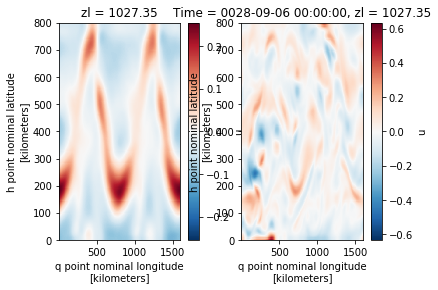

In [20]:
plt.subplot(1,2,1)
um.isel(zl=0).plot()

plt.subplot(1,2,2)
ue.isel(zl=0).plot()

# Thickness-weighted eddy-mean (time mean) decomposition
# $u = \overline{u} + u'$, $\overline{u} = \frac{\overline{uh}}{\overline{h}}$, $u' = u - \overline{u}$

In [7]:
# Function for computing mean and eddy transport
def transport(u, v, h, grid):
    
    hu = grid.interp(h, 'X', boundary='fill')
    hv = grid.interp(h, 'Y', boundary='fill')
    
    # compute mean and eddy fields (think about how to define the mean flow)
    # thickness-weighted average
    hum = hu.mean('Time')
    um = (hu * u).mean('Time') / hum
    
    hvm = hv.mean('Time')
    vm = (hv * v).mean('Time') / hvm
    
    ue = u - um
    hue = hu - hum

    ve = v - vm
    hve = hv - hvm
    
    # compute transport terms
    umo = um * hum
    ueo = (ue * hue).mean('Time')
    
    vmo = vm * hvm
    veo = (ve * hve).mean('Time')
    
    return umo, ueo, vmo, veo  

def eddy_form_stress(h, g, dx, dy, grid):
    
    hm = h.mean('Time')
    he = h - hm
    
    hm_x = grid.interp(grid.diff(hm, 'X', boundary='fill')/dx, 'X', boundary='fill')
    hm_y = grid.interp(grid.diff(hm, 'Y', boundary='fill')/dy, 'Y', boundary='fill')
    
    he_x = grid.interp(grid.diff(he, 'X', boundary='fill')/dx, 'X', boundary='fill')
    he_y = grid.interp(grid.diff(he, 'Y', boundary='fill')/dy, 'Y', boundary='fill')
    
    FS_mx1 = g * hm.isel(zl=0) * hm_x.isel(zl=1)
    FS_ex1 = g * (he.isel(zl=0) * he_x.isel(zl=1)).mean('Time')
    
    FS_mx2 = g * hm.isel(zl=1) * hm_x.isel(zl=0)
    FS_ex2 = g * (he.isel(zl=1) * he_x.isel(zl=0)).mean('Time')
    
    FS_my1 = g * hm.isel(zl=0) * hm_y.isel(zl=1)
    FS_ey1 = g * (he.isel(zl=0) * he_y.isel(zl=1)).mean('Time')
    
    FS_my2 = g * hm.isel(zl=1) * hm_y.isel(zl=0)
    FS_ey2 = g * (he.isel(zl=1) * he_y.isel(zl=0)).mean('Time')

    return FS_mx1, FS_ex1, FS_mx2, FS_ex2, FS_my1, FS_ey1, FS_my2, FS_ey2  

# Function for computing topographic form stress
def topo_form_stress(h, nb, dx, dy, g, gp, grid):
    
    hm = h.mean('Time')
    
    nb_x = grid.diff(nb, 'X', boundary='fill')/dx
    nb_x = - grid.interp(nb_x, 'X', boundary='fill') # minus sign is required because D is depth
    
    nb_y = grid.diff(nb, 'Y', boundary='fill')/dy
    nb_y = - grid.interp(nb_y, 'Y', boundary='fill') # minus sign is required because D is depth    
    
    TFS_x = g * (nb_x * hm)
    TFS1_x = gp * (nb_x * hm.isel(zl=1))
    
    TFS_y = g * (nb_y * hm)
    TFS1_y = gp * (nb_y * hm.isel(zl=1))
    
    return TFS_x, TFS1_x, TFS_y, TFS1_y

In [8]:
ts_idx = 730 # start index for equilibrium time series (consider data for last 30 years)
ds = ds1.isel(Time = slice(ts_idx, len(ds1.Time)))

In [9]:
g = 9.8 
gp = g * (ds.zl.isel(zl=1) - ds.zl.isel(zl=0))/ds.zl.isel(zl=0)
gp = gp.values
print(g, gp)

9.8 0.00533000000000023


# Zonal and meridional transport decomposition into mean and eddy parts
# $umo = \overline{u}\overline{h}$, $ueo = \overline{u'h'}$

In [15]:
umo, ueo, vmo, veo = transport(ds.u, ds.v, ds.h, grid)

In [16]:
umo = umo.compute()
ueo = ueo.compute()
vmo = vmo.compute()
veo = veo.compute()

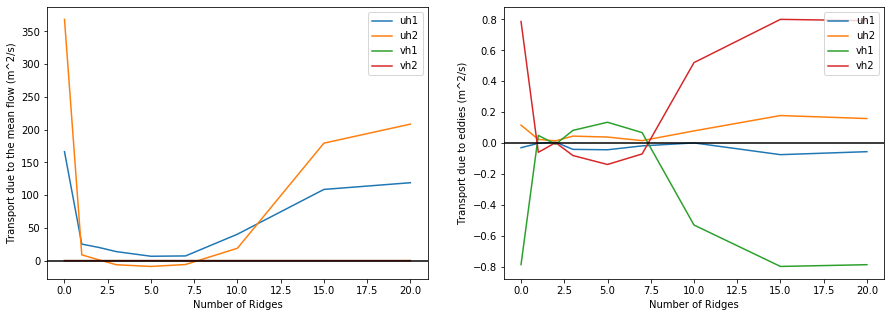

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(n_ridge, umo.mean(dim = ['yh','xq']))
plt.plot(n_ridge, vmo.mean(dim = ['yq','xh']))
plt.axhline(y=0., color='k')
plt.ylabel('Transport due to the mean flow (m^2/s)')
plt.xlabel('Number of Ridges')
plt.legend(['uh1','uh2', 'vh1','vh2'])

plt.subplot(1,2,2)
plt.plot(n_ridge, ueo.mean(dim = ['yh','xq']))
plt.plot(n_ridge, veo.mean(dim = ['yq','xh']))
plt.axhline(y=0., color='k')
plt.ylabel('Transport due to eddies (m^2/s)')
plt.xlabel('Number of Ridges')
plt.legend(['uh1','uh2', 'vh1','vh2'])

# Eddy form stress decomposition into mean and eddy parts
# $FS_m = g\overline{h_i}\nabla\overline{h_{2-i}}$, $FS_e = g\overline{h_i'\nabla h_{2-i}'}$

In [20]:
FS_mx1, FS_ex1, FS_mx2, FS_ex2, FS_my1, FS_ey1, FS_my2, FS_ey2 = eddy_form_stress(ds.h, g, ds.dxCu, ds.dyCv, grid)

In [21]:
FS_mx1 = FS_mx1.compute()
FS_ex1 = FS_ex1.compute()
FS_mx2 = FS_mx2.compute()
FS_ex2 = FS_ex2.compute()

FS_my1 = FS_my1.compute()
FS_ey1 = FS_ey1.compute()
FS_my2 = FS_my2.compute()
FS_ey2 = FS_ey2.compute()

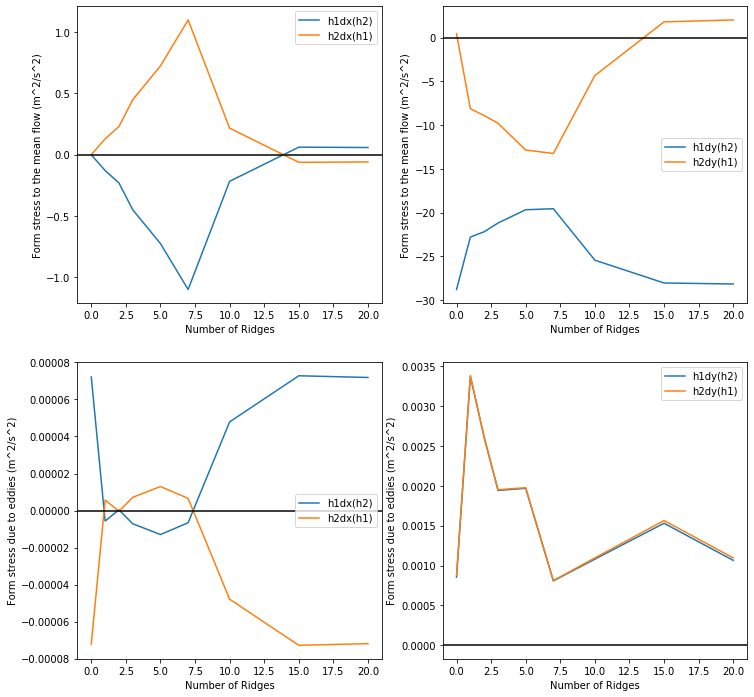

In [22]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(n_ridge, FS_mx1.mean(dim = ['yh','xh']))
plt.plot(n_ridge, FS_mx2.mean(dim = ['yh','xh']))
plt.axhline(y=0., color='k')
plt.ylabel('Form stress to the mean flow (m^2/s^2)')
plt.xlabel('Number of Ridges')
plt.legend(['h1dx(h2)','h2dx(h1)'])

plt.subplot(2,2,2)
plt.plot(n_ridge, FS_my1.mean(dim = ['yh','xh']))
plt.plot(n_ridge, FS_my2.mean(dim = ['yh','xh']))
plt.axhline(y=0., color='k')
plt.ylabel('Form stress to the mean flow (m^2/s^2)')
plt.xlabel('Number of Ridges')
plt.legend(['h1dy(h2)','h2dy(h1)'])

plt.subplot(2,2,3)
plt.plot(n_ridge, FS_ex1.mean(dim = ['yh','xh']))
plt.plot(n_ridge, FS_ex2.mean(dim = ['yh','xh']))
plt.axhline(y=0., color='k')
plt.ylabel('Form stress due to eddies (m^2/s^2)')
plt.xlabel('Number of Ridges')
plt.legend(['h1dx(h2)','h2dx(h1)'])

plt.subplot(2,2,4)
plt.plot(n_ridge, FS_ey1.mean(dim = ['yh','xh']))
plt.plot(n_ridge, FS_ey2.mean(dim = ['yh','xh']))
plt.axhline(y=0., color='k')
plt.ylabel('Form stress due to eddies (m^2/s^2)')
plt.xlabel('Number of Ridges')
plt.legend(['h1dy(h2)','h2dy(h1)'])

# Topographic form stress
# $TS_g = g\Sigma_i\overline{h_i}\nabla\eta_b$, $TS_{gp} = g'\overline{h_2}\nabla\eta_b$

In [23]:
TFS_x, TFS1_x, TFS_y, TFS1_y = topo_form_stress(ds.h, ds.depth_ocean, ds.dxCu, ds.dyCv, g, gp, grid)

In [24]:
TFS_x = TFS_x.compute()
TFS1_x = TFS1_x.compute()
TFS_y = TFS_y.compute()
TFS1_y = TFS1_y.compute()

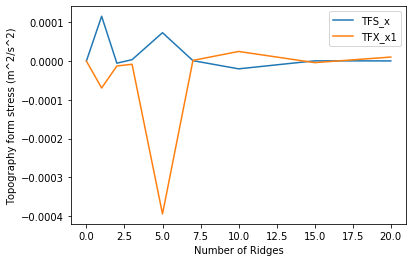

In [34]:
plt.plot(n_ridge, TFS_x.mean(dim = ['yh','xh']).sum('zl') + TFS1_x.mean(dim = ['yh','xh']))
plt.plot(n_ridge, TFS1_x.mean(dim = ['yh','xh']))
#plt.plot(n_ridge, TFS_y.mean(dim = ['yh','xh']))
#plt.plot(n_ridge, TFS1_y.mean(dim = ['yh','xh']))
#plt.axhline(y=0., color='k')
plt.ylabel('Topography form stress (m^2/s^2)')
plt.xlabel('Number of Ridges')
plt.legend(['TFS_x', 'TFX_x1'])

# Bottom friction term

In [35]:
BD_x = ds.taux_bot.mean('Time').compute()
BD_y = ds.tauy_bot.mean('Time').compute()

In [42]:
# Save diagnostics to file
#ds_save = xr.Dataset([umo, ueo, vmo, veo, FS_mx1, FS_ex1, FS_mx2, FS_ex2, FS_my1, FS_ey1, FS_my2, FS_ey2, TFS_x, TFS1_x, TFS_y, TFS1_y])
ds_save = dsgrid
ds_save = ds_save.assign(umo = umo, vmo = vmo, ueo = ueo, veo = veo)
ds_save = ds_save.assign(FS_mx1 = FS_mx1, FS_ex1 = FS_ex1, FS_mx2 = FS_mx2, FS_ex2 = FS_ex2)
ds_save = ds_save.assign(FS_my1 = FS_my1, FS_ey1 = FS_ey1, FS_my2 = FS_my2, FS_ey2 = FS_ey2)
ds_save = ds_save.assign(TFS_x = TFS_x, TFS1_x = TFS1_x, TFS_y = TFS_y, TFS1_y = TFS1_y)
ds_save = ds_save.assign(BD_x = BD_x, BD_y = BD_y)

print(ds_save)

ds_save.to_netcdf(path=ppdir + 'H_500_diagnostics.nc')

<xarray.Dataset>
Dimensions:      (Time: 1, nr: 9, nv: 2, xh: 400, xq: 400, yh: 200, yq: 200, zl: 2)
Coordinates:
  * xh           (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yh           (yh) float64 2.0 6.0 10.0 14.0 18.0 ... 786.0 790.0 794.0 798.0
  * Time         (Time) object 0025-12-26 00:00:00
  * nv           (nv) float64 1.0 2.0
  * xq           (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
  * yq           (yq) float64 4.0 8.0 12.0 16.0 20.0 ... 788.0 792.0 796.0 800.0
  * zl           (zl) float64 1.027e+03 1.028e+03
Dimensions without coordinates: nr
Data variables:
    geolon       (yh, xh) float32 ...
    geolat       (yh, xh) float32 ...
    geolon_c     (yq, xq) float32 ...
    geolat_c     (yq, xq) float32 ...
    geolon_u     (yh, xq) float32 ...
    geolat_u     (yh, xq) float32 ...
    geolon_v     (yq, xh) float32 ...
    geolat_v     (yq, xh) float32 ...
    area_t       (yh, xh) float32 ...
    depth_ocean  (yh, xh) float

/home/Hemant.Khatri/anaconda3/envs/analysis_python3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [49]:
hm_x = grid.interp(grid.diff(ds.h, 'X', boundary='fill') / ds.dxCu, 'X', boundary='fill')
hm_x

<xarray.DataArray 'mul-a983c7950494b318551c62334cbfe786' (nr: 9, Time: 1096, zl: 2, yh: 200, xh: 400)>
dask.array<mul, shape=(9, 1096, 2, 200, 400), dtype=float64, chunksize=(1, 11, 2, 200, 398), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) object 0021-01-06 00:00:00 ... 0050-12-20 00:00:00
  * zl       (zl) float64 1.027e+03 1.028e+03
  * yh       (yh) float64 2.0 6.0 10.0 14.0 18.0 ... 786.0 790.0 794.0 798.0
  * xh       (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
Dimensions without coordinates: nr

In [53]:
hm_y = grid.interp(grid.diff(ds.h, 'Y', boundary='fill')/ds.dyCv, 'Y', boundary='fill')
print(hm_y)

<xarray.DataArray 'mul-ea3fd2ad462e16fa6c22711ad3cf70f8' (nr: 9, Time: 1096, zl: 2, yh: 200, xh: 400)>
dask.array<mul, shape=(9, 1096, 2, 200, 400), dtype=float64, chunksize=(1, 11, 2, 198, 400), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) object 0021-01-06 00:00:00 ... 0050-12-20 00:00:00
  * zl       (zl) float64 1.027e+03 1.028e+03
  * yh       (yh) float64 2.0 6.0 10.0 14.0 18.0 ... 786.0 790.0 794.0 798.0
  * xh       (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
Dimensions without coordinates: nr


In [54]:
FS_mx1 = ds.h.isel(zl=0) * hm_y.isel(zl=1)
print(FS_mx1)

<xarray.DataArray (nr: 9, Time: 1096, yh: 200, xh: 400)>
dask.array<mul, shape=(9, 1096, 200, 400), dtype=float64, chunksize=(1, 11, 198, 400), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) object 0021-01-06 00:00:00 ... 0050-12-20 00:00:00
  * yh       (yh) float64 2.0 6.0 10.0 14.0 18.0 ... 786.0 790.0 794.0 798.0
  * xh       (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
Dimensions without coordinates: nr


In [43]:
ds1.close()
client.close()
cluster.close()